# Retention Scoring - PROD - Redshift - ALL NHL Data
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* July 14, 2022

## Hypothesis
This notebook will test the retention model features and the goal is to check how the accuracy and scores look when we train the model only with Canucks data compared to all NHL data.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

from pycaret.classification import *

In [2]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

NHNQ-LJHW
Successully logged into Start URL: https://stellaralgo.awsapps.com/start#/


In [3]:
session = boto3.session.Session(profile_name='Stellaralgo-DataScienceAdmin')
client = session.client('redshift')

In [4]:
teams = [{'lkupclientid': 7, 'clientcode': 'canucks', 'stlrDBName': 'stlrcanucks'},
         {'lkupclientid': 33, 'clientcode': 'vgk', 'stlrDBName': 'stlrvgk'},
         {'lkupclientid': 36, 'clientcode': 'flames', 'stlrDBName': 'stlrflames'},
         {'lkupclientid': 55, 'clientcode': 'coyotes', 'stlrDBName': 'stlrcoyotes'},
         {'lkupclientid': 93, 'clientcode': 'nhlpanthers', 'stlrDBName': 'stlrnhlpanthers'}]

all_data = []
for team in teams:
    CLUSTER = 'prod-app'
    DBNAME = team['stlrDBName']

    creds = client.get_cluster_credentials(                
        ClusterIdentifier = CLUSTER,
        DbUser = 'admin',
        DbName = DBNAME,
        DbGroups = ['admin_group'],
        AutoCreate=True
    )

    # create a connection & cursor and call the stored procedure
    conn = psycopg2.connect(
        host = 'prod-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com',
        port = 5439,
        user = creds['DbUser'],
        password = creds['DbPassword'],
        database = DBNAME
    )
    
    # call the stored proc to get data for the product propensity model
    cur = conn.cursor()
    cur.execute(f"CALL {team['stlrDBName']}.ds.getretentionmodeldata({team['lkupclientid']},2010, 2022, 'temp_cursor')")

    # create a named cursor based on the cursor name passed in above
    named_cursor = conn.cursor('temp_cursor')
    data = named_cursor.fetchall()

    # load the data and columns into a data frame
    cols = [row[0] for row in named_cursor.description]
    df = pd.DataFrame(data=data, columns=cols)
    all_data.append(df)
    
    conn.commit()

    

In [14]:
dfObj = pd.DataFrame(columns=['lkupclientid',
    'dimcustomermasterid',
    'year', 
    'productgrouping',
    'totalspent',
    'recentdate',
    'attendancepercent',
    'renewedbeforedays',
    'source_tenure',
    'tenure',
    'disttovenue',
    'recency',
    'missed_games_1',
    'missed_games_2',
    'missed_games_over_2',
    'forward_records',
    'opentosendratio',
    'clicktosendratio',
    'clicktoopenratio',
    'gender',
    'phonecall',
    'inperson_contact',
    'isnextyear_buyer'])

In [15]:
for data in all_data:
    dfObj= dfObj.append(data)
dfObj.head()

,lkupclientid,dimcustomermasterid,year,productgrouping,totalspent,recentdate,attendancepercent,renewedbeforedays,source_tenure,tenure,...,missed_games_2,missed_games_over_2,forward_records,opentosendratio,clicktosendratio,clicktoopenratio,gender,phonecall,inperson_contact,isnextyear_buyer
0,7,30747,2018,Quarter,5048.4,2019-04-02 00:00:00,1.0,41,2555,806,...,0,0,0,1.91,0.42,0.22,Unknown,0,0,0
1,7,31295,2017,Full Season,8944.5,2018-04-05 00:00:00,0.64,17,3285,951,...,5,1,0,1.26,0.18,0.14,Male,0,0,1
2,7,5738,2018,Full Season,3657.08,2019-04-02 00:00:00,0.73,190,1460,386,...,0,1,0,1.24,0.31,0.25,Unknown,0,0,1
3,7,11588,2018,Quarter,2364.12,2019-03-30 00:00:00,0.91,82,2920,1310,...,0,0,0,5.90,0.36,0.06,Unknown,0,0,1
4,7,17612,2017,Mini Pack,1200.0,2018-03-02 00:00:00,0.8,64,5110,903,...,0,0,0,3.20,0.70,0.22,Unknown,0,0,0


In [16]:
dfObj['lkupclientid'].unique()

array([7, 33, 36, 55, 93], dtype=object)

In [23]:
# choose the features for the stellar base retention model
features = [
    "lkupclientid",
    "dimcustomermasterid",
    "year", 
    "productgrouping",
    "totalspent",
    "recentdate",
    "attendancepercent",
    "renewedbeforedays",
    "source_tenure",
    "tenure",
    "disttovenue",
    "recency",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "forward_records",
    "opentosendratio",
    "clicktosendratio",
    "clicktoopenratio",
    "gender",
    "phonecall",
    "inperson_contact",
    "isnextyear_buyer"
]

# copy your main dataframe
df_dataset = dfObj

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2020]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (89202, 23)
Unseen Data For Predictions: (1733, 23)



In [24]:
setup(
    data= df_train, 
    target="isnextyear_buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=[
        "dimcustomermasterid",
        "lkupclientid",
        "productgrouping",
        "year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "opentosendratio",
        "clicktosendratio",
        "clicktoopenratio",
        "attendancepercent",
        "forward_records",
        "disttovenue",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "recency",
        "phonecall",
        "renewedbeforedays",
        "source_tenure",
        "totalspent"
    ]
);

In [25]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8438,0.9167,0.8992,0.8370,0.8670,0.6785,0.6811,0.2540


In [26]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8458,0.9169,0.8959,0.8419,0.8680,0.6831,0.6850
1,0.8441,0.9177,0.9017,0.8358,0.8675,0.6788,0.6817
2,0.8432,0.9175,0.8996,0.8359,0.8665,0.6771,0.6798
3,0.8395,0.9138,0.8949,0.8337,0.8632,0.6696,0.6721
4,0.8441,0.9156,0.9005,0.8365,0.8673,0.6790,0.6817
5,0.8466,0.9205,0.9052,0.8371,0.8698,0.6839,0.6870
6,0.8495,0.9214,0.9056,0.8408,0.8720,0.6900,0.6928
7,0.8438,0.9157,0.8931,0.8409,0.8662,0.6791,0.6809
8,0.8375,0.9116,0.8966,0.8300,0.8620,0.6652,0.6681
9,0.8442,0.9164,0.8996,0.8373,0.8673,0.6793,0.6819


In [27]:
df_inference_year = dfObj.loc[dfObj["year"] >= 2021]
df_inference = df_inference_year.loc[df_inference_year["lkupclientid"] == 7]
df_inference = df_inference.fillna(0)
df_inference.shape

(5143, 23)

In [28]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupclientid,dimcustomermasterid,year,productgrouping,totalspent,recentdate,attendancepercent,renewedbeforedays,source_tenure,tenure,...,opentosendratio,clicktosendratio,clicktoopenratio,gender,phonecall,inperson_contact,isnextyear_buyer,Label,Score_0,Score_1
5,7,27289,2021,Full Season,9175.0,2022-04-26,0.14,45,730,252,...,2.48,0.36,0.14,Unknown,0,0,0,1,0.1642,0.8358
29,7,124513,2021,Quarter,1578.5,2022-03-13,0.17,19,1460,1345,...,1.78,0.20,0.11,Unknown,0,0,0,0,0.8065,0.1935
32,7,129622,2021,Full Season,5276.0,2022-04-28,0.94,32,1095,990,...,3.05,0.05,0.01,Unknown,0,0,1,1,0.4464,0.5536
47,7,35722,2021,Full Season,8166.8,2022-04-28,0.46,46,365,253,...,2.79,0.16,0.06,Unknown,0,0,1,1,0.1590,0.8410
48,7,35784,2021,Full Season,13266.9,2022-04-26,0.30,102,10950,2435,...,1.24,0.06,0.05,Unknown,0,0,1,0,0.7529,0.2471


In [29]:
new_predictions["Label"].value_counts()

0    3808
1    1335
Name: Label, dtype: int64

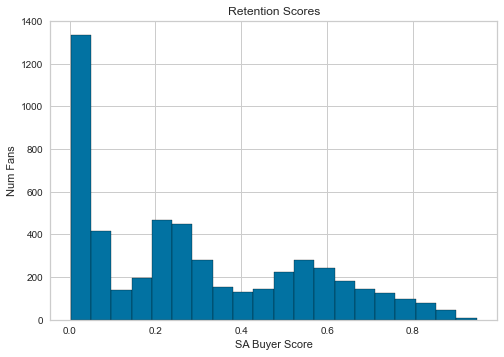

In [30]:
plt.hist(new_predictions["Score_1"], bins=20, edgecolor='black')
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.show()

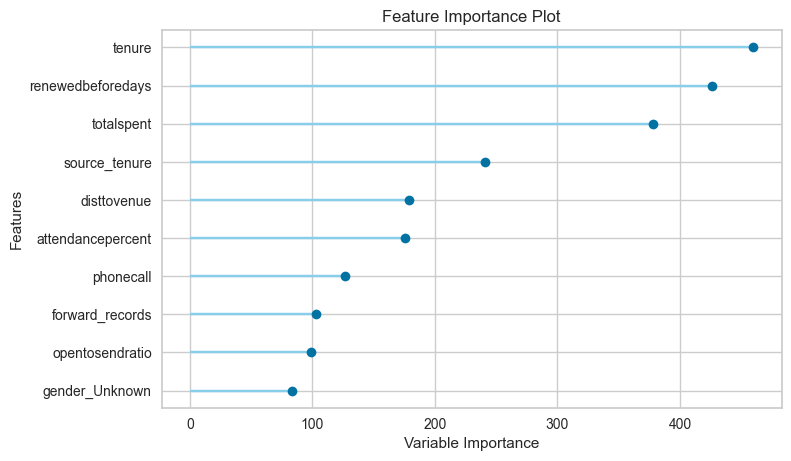

In [31]:
plot_model(final_model, plot='feature')

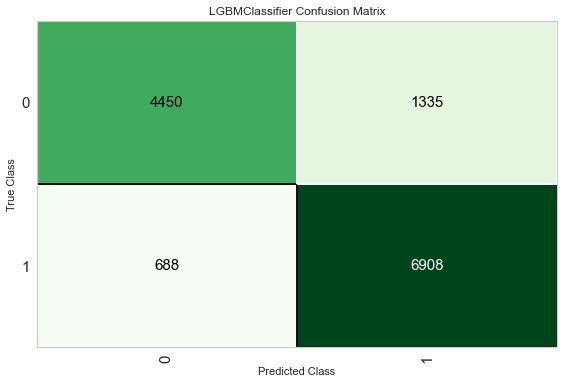

In [32]:
plot_model(final_model, plot='confusion_matrix')

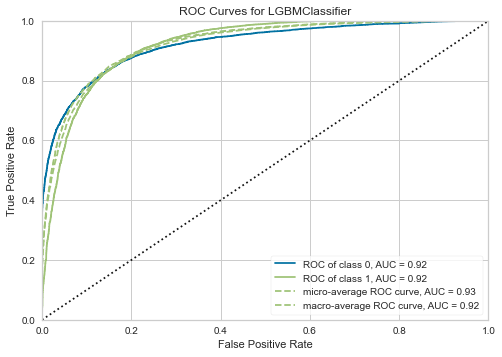

In [33]:
plot_model(final_model, plot='auc')

### Done